Generate intial word embedding for headlines and description

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.

In [113]:
FN = 'vocabulary-embedding'

In [114]:
seed=42

In [115]:
vocab_size = 40000

In [116]:
embedding_dim = 100

In [117]:
lower = True # lower case the text

# read tokenized headlines and descriptions

In [118]:
import pickle
import numpy as np
FN0 = 'sample10000' # this is the name of the data file which I assume you already have
with open('%s.pickle'%FN0, 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project

In [119]:
if lower:
    heads = [h.lower() for h in heads]

In [120]:
if lower:
    desc = [h.lower() for h in desc]

In [121]:
i=0
heads[i]

'worcester breakfast club for veterans gives hunger its marching orders'

In [122]:
desc[i]

'veterans saluted worcester &apos;s first ever breakfast club for ex-soldiers which won over hearts , minds and bellies . the worcester breakfast club for hm forces veterans met at the postal order in foregate street at 10am on saturday . the club is designed to allow veterans a place to meet , socialise , eat and drink , giving hunger and loneliness their marching orders . father-of-two dave carney , aged 43 , of merrimans hill , worcester , set up the club after being inspired by other similar clubs across the country . he said : &quot; as you can see from the picture , we had a good response . five out of the 10 that attended said they saw the article in the newspaper and turned up . &quot; we even had an old chap travel from droitwich and he was late on parade by three hours . &quot; it &apos;s generated a lot of interest and i estimate ( from other veterans who saw the article ) that next month &apos;s meeting will attract about 20 people . onwards and upwards . &quot; he said the

In [123]:
keywords

In [124]:
len(heads),len(set(heads))

(10000, 9941)

In [125]:
len(desc),len(set(desc))

(10000, 9898)

# build vocabulary

In [126]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = list(map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1])))
    return vocab, vocabcount

In [127]:
vocab, vocabcount = get_vocab(heads+desc)

most popular tokens

In [128]:
print(vocab[:50])
print('...',len(vocab))

['the', ',', '.', 'and', 'to', 'of', 'a', 'in', 'for', 'is', '&quot;', 'on', 'that', ':', 'with', '’', 'it', '/', 'at', 'as', ')', '&apos;s', '(', 'was', 'by', 'i', 'be', 'this', 'are', 'from', 's', 'he', 'you', 'have', 'will', 'has', 'said', 'we', 'an', 'or', '“', 'but', 'not', '”', 'his', 'more', 'they', 'their', '-', 'new']
... 138279


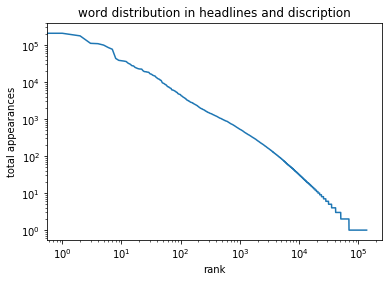

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

always nice to see [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

# Index words

In [130]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [131]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [132]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word Embedding

## read GloVe

In [133]:
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
#datadir_base = os.path.expanduser(os.path.join('glove/', '.keras'))
#datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join('glove/', fname)
#if not os.path.exists(glove_name):
#    path = 'glove.6B.zip'
#    path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
#    !unzip {datadir}/{path}

In [134]:
#unix
#glove_n_symbols = !wc -l {glove_name}
#glove_n_symbols = int(glove_n_symbols[0].split()[0])
#glove_n_symbols

#windows
glove_n_symbols = !find /v /c "" {glove_name}
glove_n_symbols = int(glove_n_symbols[1].split()[2])
glove_n_symbols

400000

In [135]:
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, encoding='utf8') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale

In [136]:
glove_embedding_weights.std()

0.040815727600190289

In [137]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## embedding matrix

use GloVe to initialize embedding matrix

In [140]:
import numpy as np

# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0

for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514 std 0.0408138249575
number of tokens, in small vocab, found in glove and copied to embedding 36525 0.913125


lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [141]:
glove_thr = 0.5

In [142]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [143]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))

# of glove substitutes found 33731


manually check that the worst substitutions we are going to do are good enough

In [144]:
for orig, sub, score in glove_match[-10:]:
    print(score, orig,'=>', idx2word[sub])

0.500077072963 berge => laurent
0.500076548828 seydou => toure
0.50007249497 cannonade => grapeshot
0.500071354978 benanti => lampanelli
0.500043683823 scoping => sketching
0.50004343399 veltman => kjær
0.500032448616 dens => lair
0.500031843282 yellowjackets => matildas
0.500027561139 bdt => tpk
0.500015693528 ambrosio => segura


build a lookup table of index of outside words to index of inside words

In [145]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Data

In [146]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

10000

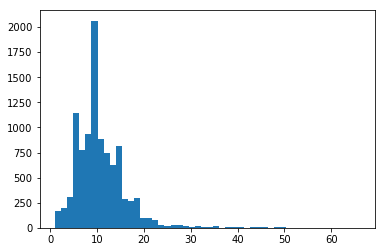

In [147]:
plt.hist(list(map(len,Y)),bins=50);

In [148]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

10000

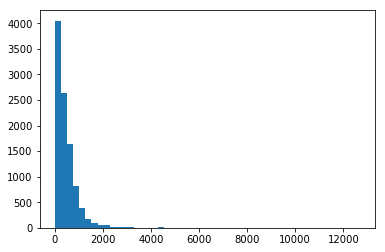

In [149]:
plt.hist(list(map(len,X)),bins=50);

In [150]:
with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [151]:
with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)